## Evaluation of input data adequacy

The final step of the `preprocess` pipeline is to check that there is enough data available for the energy consumption of the building under study. Baseline energy consumption data must cover at least one (1) full year before any energy efficiency intervention. In addition, data must be available for over a certain percentage of hours in each calendar month. The default value of this percentage is 10%, but it is a user-defined parameter, so it can be adjusted.

The relevant functionality is presented through an example.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from eensight.config import ConfigLoader
from eensight.methods.preprocessing.adequacy import (
    expand_dates, 
    filter_data, 
    check_data_adequacy
)
from eensight.settings import PROJECT_PATH
from eensight.utils import load_catalog

%matplotlib inline

### Load dataset

First, we load the catalog for one of the available datasets (the one with `site_id="b03"`):

In [3]:
catalog = load_catalog(store_uri="../../../data", site_id="b03", namespace="train")

Get the data produced by the `preprocess` pipeline so far:

In [4]:
features = catalog.load("train.validated-features")
labels = catalog.load("train.validated-labels")

### Expand date indices

The function `eensight.methods.preprocessing.adequacy.expand_dates` expands the datetime index of a dataframe to make sure that all full days in its period are included. This includes both missing days and days that are included in the dataset but do not contain all hours.

As an example, the first day in the indices of the features and labels above is not a full one (it starts at 18:45, instead of 00:00):  

In [5]:
labels.index[0]

Timestamp('2015-11-18 18:45:00')

This is resolved after applying `expand_dates`:

In [6]:
labels = expand_dates(labels)
labels.index[0]

Timestamp('2015-11-18 00:00:00', freq='15T')

Similarly for features:

In [7]:
features.index[0]

Timestamp('2015-11-18 18:45:00')

In [8]:
features = expand_dates(features)
features.index[0]

Timestamp('2015-11-18 00:00:00', freq='15T')

### Filter values

Before evaluating the adequacy of the available data, `eensight` screens for non-physically plausible values in the consumption data.

In [9]:
params_filter = {
    "allow_zero": True,
    "allow_negative": False,
}

labels["consumption"] = filter_data(labels["consumption"], **params_filter)

### Ensure that enough training data is available

Missing data is data where either consumption values are missing or feature values are missing:

In [10]:
max_missing_pct = 0.1
missing_per_month = check_data_adequacy(features, labels, max_missing_pct=max_missing_pct)

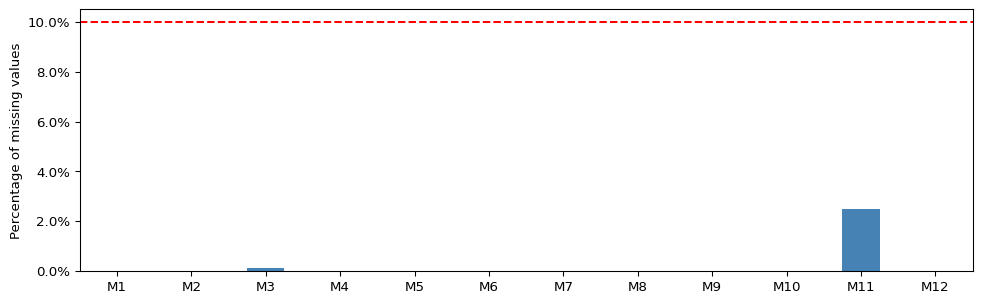

In [12]:
fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

ax.axhline(y=100 * max_missing_pct, color="red", linestyle="dashed")

subset = 100 * missing_per_month.mask(missing_per_month['missing_pct'] <= max_missing_pct, 0) 
subset.plot.bar(rot=25, ax=ax, color='#C71585', legend=False)

subset = 100 * missing_per_month.mask(missing_per_month['missing_pct'] > max_missing_pct, 0)
subset.plot.bar(rot=0, ax=ax, color='#4682B4', legend=False)

ax.set_ylabel('Percentage of missing values')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

### Parameters

The parameters of this stage - as they can be found in the `eensight/conf/base/parameters/preprocess.yml` file are:

In [13]:
params = ConfigLoader(PROJECT_PATH / "conf").get("parameters*", "parameters*/**", "**/parameters*")

In [15]:
{
    "adequacy": params["adequacy"],
    "filter": params["filter"],
}

{
    'adequacy': {'max_missing_pct': 0.1},
    'filter': {'min_value': None, 'max_value': None, 'allow_zero': True, 'allow_negative': False}
}

---------------